# **Convolutional Neural Networks (CNNs) for MNIST Classification using PyTorch**  

Welcome to this practical session on Convolutional Neural Networks (CNNs)! In this notebook, we will implement a CNN using PyTorch to classify handwritten digits from the MNIST dataset.  

Before you begin, make sure to review the **slides in the provided folder**, which introduce the key concepts behind CNNs, including:  
- How convolutional layers work  
- The role of pooling layers  
- Activation functions and feature extraction  
- How CNNs improve performance in image classification tasks 

This is a cool link to visualize CNNs on the MNIST dataset: https://adamharley.com/nn_vis/cnn/3d.html

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

#import helper
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

device = "cpu" # set to cuda if GPU or mps if MAC M1+
print(device)

cpu


In [2]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download MNIST
train_set = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

In [3]:
training_data = enumerate(trainloader)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # Images come in batches of 64. With a dimension of 28x28 pixels. 1 = Grayscale, 3 = Colour.
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


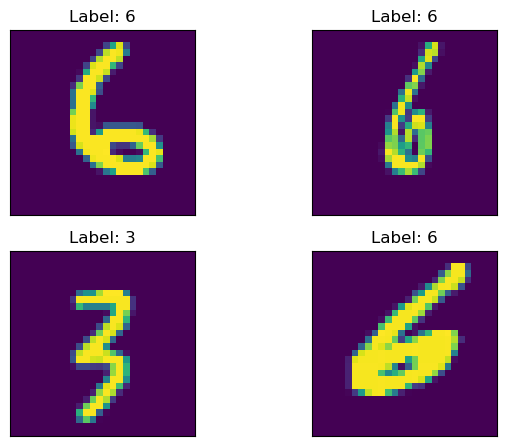

In [4]:
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0])
    plt.title("Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
     

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()
        # Convolutional Neural Network Layer 
        self.cnn_layers = nn.Sequential(
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (64, 1, 28, 28) 
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2), # stride default value is kernel_size
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(), 
                nn.MaxPool2d(kernel_size=2) 
        )

        # Fully connected NN
        self.linear_layers = nn.Sequential(
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # 20% of Neurons randomly set to 0. Can you tell me why?
                ## To prevent the model from relying too much on specific neurons
                ## To encourage the network to learn redundant, more robust features
                ## To help combat overfitting, especially in small or clean datasets like MNIST
                nn.Linear(in_features=64, out_features=10) 
        )

    # execute the forwad pass
    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1) # Turn into a 1D tensor
        x = self.linear_layers(x)
        x = F.log_softmax(x, dim=1) # What is wrong with this line?
        return x
     

In [6]:
model = CNN()
model.to(device)
print(model)

CNN(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [7]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()     

## Cross-Entropy Loss in PyTorch: And the common softmax bug


### Softmax Function
The **Softmax** function is often used in multi-class classification problems. It converts logits (raw predictions) into probabilities by exponentiating and normalising them across all classes. Mathematically, it is defined as:

$$
\text{Softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

Where:
- $ z_i $ is the score or logit for the $ i $-th class.
- $ C $ is the total number of classes.
- The denominator is the sum of the exponentials of the logits for all classes.

### Cross Entropy Loss
**Cross Entropy Loss** is a loss function commonly used for classification tasks, especially with Softmax. It measures the dissimilarity between the true label distribution and the predicted distribution. The formula is:

$$
L = -\sum_{i=1}^{C} y_i \log(p_i)
$$

Where:
- $ y_i $ is the true probability distribution (usually one-hot encoded).
- $ p_i $ is the predicted probability for class \( i \) (the output of the Softmax function).
- $ C $ is the number of classes.

### How PyTorch Applies Softmax
In PyTorch, `torch.nn.CrossEntropyLoss()` combines the softmax activation and the cross-entropy loss function into one efficient operation. You do not need to manually apply `Softmax` before passing the logits to `CrossEntropyLoss`, as PyTorch applies it internally.

The `CrossEntropyLoss` in PyTorch expects raw logits as input (before softmax) and applies the softmax function internally during the loss calculation.

### To do:

Change the code to avoid explicitly using softmax and compare your results.

In [8]:
epochs = 10  # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # Prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(images)  # raw logits
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    # Model evaluation
    model.eval() 
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)  # raw logits
            test_loss += criterion(logits, labels)

            # Get top predicted class without applying softmax
            _, top_class = logits.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))
    
    # Store average losses
    train_losses.append(train_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {train_loss / len(trainloader):.4f}  "
          f"Testing loss: {test_loss / len(testloader):.4f}  "
          f"Test accuracy: {accuracy / len(testloader):.4f}")


Epoch: 1/10  Training loss: 0.8028  Testing loss: 0.2127  Test accuracy: 0.9355
Epoch: 2/10  Training loss: 0.2254  Testing loss: 0.1277  Test accuracy: 0.9600
Epoch: 3/10  Training loss: 0.1550  Testing loss: 0.0956  Test accuracy: 0.9703
Epoch: 4/10  Training loss: 0.1195  Testing loss: 0.0732  Test accuracy: 0.9765
Epoch: 5/10  Training loss: 0.0997  Testing loss: 0.0627  Test accuracy: 0.9804
Epoch: 6/10  Training loss: 0.0886  Testing loss: 0.0574  Test accuracy: 0.9822
Epoch: 7/10  Training loss: 0.0796  Testing loss: 0.0482  Test accuracy: 0.9852
Epoch: 8/10  Training loss: 0.0730  Testing loss: 0.0482  Test accuracy: 0.9840
Epoch: 9/10  Training loss: 0.0666  Testing loss: 0.0453  Test accuracy: 0.9854
Epoch: 10/10  Training loss: 0.0606  Testing loss: 0.0396  Test accuracy: 0.9872


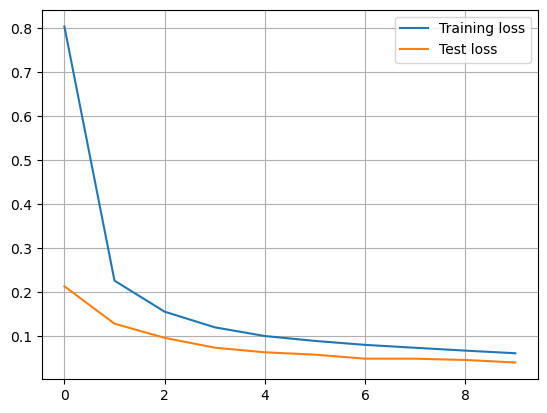

In [9]:
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses], label='Training loss')
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses], label='Test loss')
plt.legend()
plt.grid()

<br>

### Model Performance Comparison: Before vs. After Removing Softmax

| Metric                | Softmax Output (Before)         | Raw Logits (After)              |
|-----------------------|----------------------------------|----------------------------------|
| Initial Training Loss | 0.9102                          | 0.8028                          |
| Final Training Loss   | 0.0769                          | **0.0606**                   |
| Initial Test Loss     | 0.2588                          | 0.2127                          |
| Final Test Loss       | 0.0519                          | **0.0396**                   |
| Initial Accuracy      | 92.55%                          | 93.55%                          |
| Final Accuracy        | 98.13%                          | **98.72%**                   |
| Loss Curve Shape      | Smooth improvement              | **Faster convergence**       |
| Gap Between Curves    | Small, good generalisation      | **Smaller gap, tighter fit** |

<br>

- After removing `torch.exp()` (i.e. softmax), the model showed:

    - lower test loss across all epochs
    
    - slightly improved accuracy

- This confirms that using raw logits directly with `CrossEntropyLoss` is both correct and more effective

<br>

In [10]:
img = images[0]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

with torch.no_grad():
    logits = model.forward(img)

torch.Size([1, 1, 28, 28])


[4.3549098e-06 3.9888077e-06 1.5337428e-05 5.8807512e-08 9.9986470e-01
 2.9588554e-08 9.1140428e-05 1.6368966e-05 1.9494646e-06 2.1032251e-06]


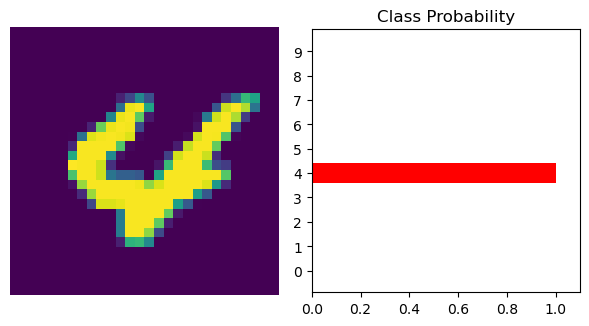

In [11]:
probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze())
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)

plt.tight_layout()

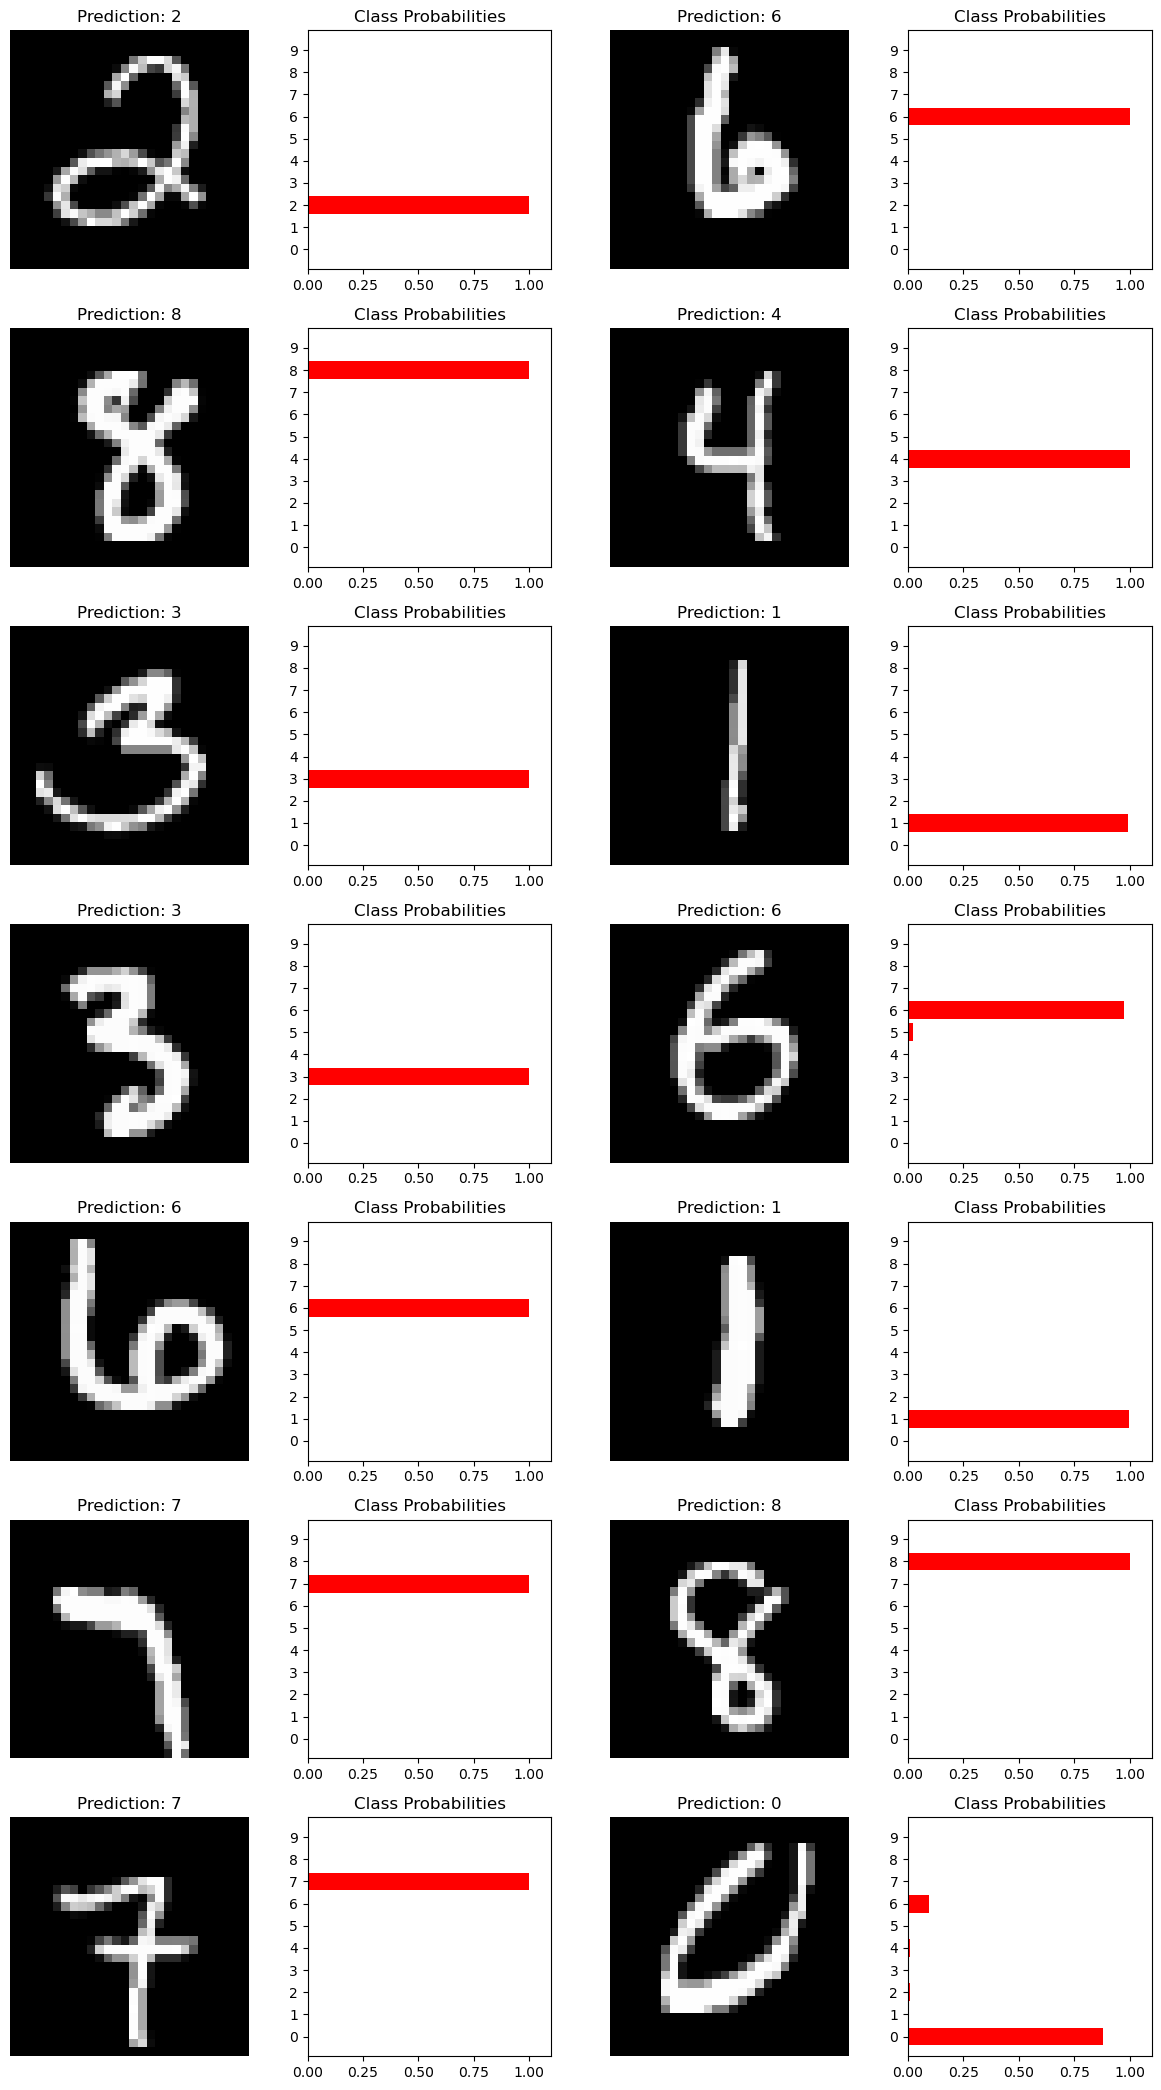

In [12]:
n_samples = 14
fig, axes = plt.subplots(nrows=n_samples // 2, ncols=4, figsize=(12, 3 * (n_samples // 2)))

for i in range(n_samples):
    img = images[i + 1].to(device).view(-1, 1, 28, 28)

    with torch.no_grad():
        logits = model(img)
    probabilities = F.softmax(logits, dim=1).cpu().numpy().squeeze()

    row = i // 2
    col_img = (i % 2) * 2        # 0 or 2
    col_bar = col_img + 1        # 1 or 3

    # Plot image
    axes[row, col_img].imshow(img.view(28, 28).cpu().numpy(), cmap="gray")
    axes[row, col_img].axis('off')
    axes[row, col_img].set_title(f"Prediction: {np.argmax(probabilities)}")

    # Plot class probabilities
    axes[row, col_bar].barh(np.arange(10), probabilities, color='r')
    axes[row, col_bar].set_aspect(0.1)
    axes[row, col_bar].set_yticks(np.arange(10))
    axes[row, col_bar].set_yticklabels(np.arange(10))
    axes[row, col_bar].set_xlim(0, 1.1)
    axes[row, col_bar].set_title("Class Probabilities")

plt.tight_layout()
plt.show()


# Assignment: Improving the MNIST Classifier

## Question 1: Data Augmentation  
Modify the given convolutional neural network to include at least one data augmentation technique. You can apply transformations such as rotation, magnification, shearing, or any other augmentation method discussed in the lecture slides.

Once you have implemented the augmentation, retrain the model and compare its performance with the original. Answer the following:  
- What augmentation technique(s) did you apply?  
- How did the augmentation affect the model's accuracy and generalisation?  
- Why do you think this augmentation was beneficial (or not)?  

In [13]:
# Data Augmentation
transform_augmented = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load dataset with data augmentation applied
train_dataset_aug = datasets.MNIST(root='./data', train=True, download=True, transform=transform_augmented)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)

train_loader_aug = torch.utils.data.DataLoader(train_dataset_aug, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

Epoch: 1/10  Training loss: 0.8376  Testing loss: 0.2404  Test accuracy: 0.9294
Epoch: 2/10  Training loss: 0.2519  Testing loss: 0.1531  Test accuracy: 0.9532
Epoch: 3/10  Training loss: 0.1711  Testing loss: 0.1016  Test accuracy: 0.9700
Epoch: 4/10  Training loss: 0.1358  Testing loss: 0.0844  Test accuracy: 0.9728
Epoch: 5/10  Training loss: 0.1159  Testing loss: 0.0699  Test accuracy: 0.9774
Epoch: 6/10  Training loss: 0.1019  Testing loss: 0.0648  Test accuracy: 0.9799
Epoch: 7/10  Training loss: 0.0927  Testing loss: 0.0573  Test accuracy: 0.9811
Epoch: 8/10  Training loss: 0.0839  Testing loss: 0.0555  Test accuracy: 0.9817
Epoch: 9/10  Training loss: 0.0776  Testing loss: 0.0547  Test accuracy: 0.9819
Epoch: 10/10  Training loss: 0.0744  Testing loss: 0.0518  Test accuracy: 0.9818


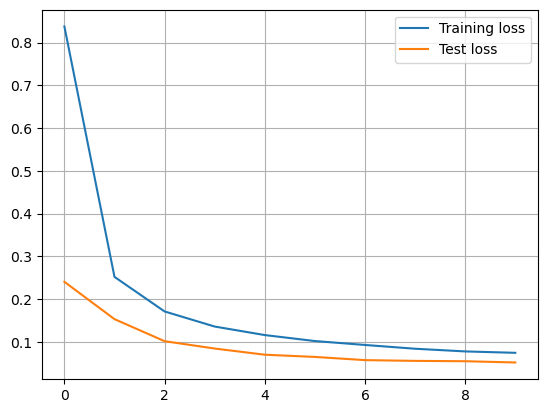

In [14]:
# Set up the CNN model, optimiser (SGD), and loss function (CrossEntropy) for multi-class classification
model = CNN()
optimizer = optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

# Training loop
epochs = 10  # The total number of iterations

train_losses = []
test_losses = []

for epoch in range(epochs):
    # Prep model for training
    model.train()
    train_loss = 0

    for idx, (images, labels) in enumerate(trainloader): 
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        output = model(images)  # raw logits
        loss = criterion(output, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    
    # Model evaluation
    model.eval() 
    test_loss = 0
    accuracy = 0

    # Turn off gradients for validation
    with torch.no_grad():
        for images, labels in testloader:
            images = images.to(device)
            labels = labels.to(device)

            logits = model(images)  # raw logits
            test_loss += criterion(logits, labels)

            # Get top predicted class without applying softmax
            _, top_class = logits.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))
    
    # Store average losses
    train_losses.append(train_loss / len(trainloader))
    test_losses.append(test_loss / len(testloader))

    print(f"Epoch: {epoch+1}/{epochs}  "
          f"Training loss: {train_loss / len(trainloader):.4f}  "
          f"Testing loss: {test_loss / len(testloader):.4f}  "
          f"Test accuracy: {accuracy / len(testloader):.4f}")

# Plot training and test loss curves with labels and grid for visual comparison
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses], label='Training loss')
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses], label='Test loss')
plt.legend()
plt.grid()

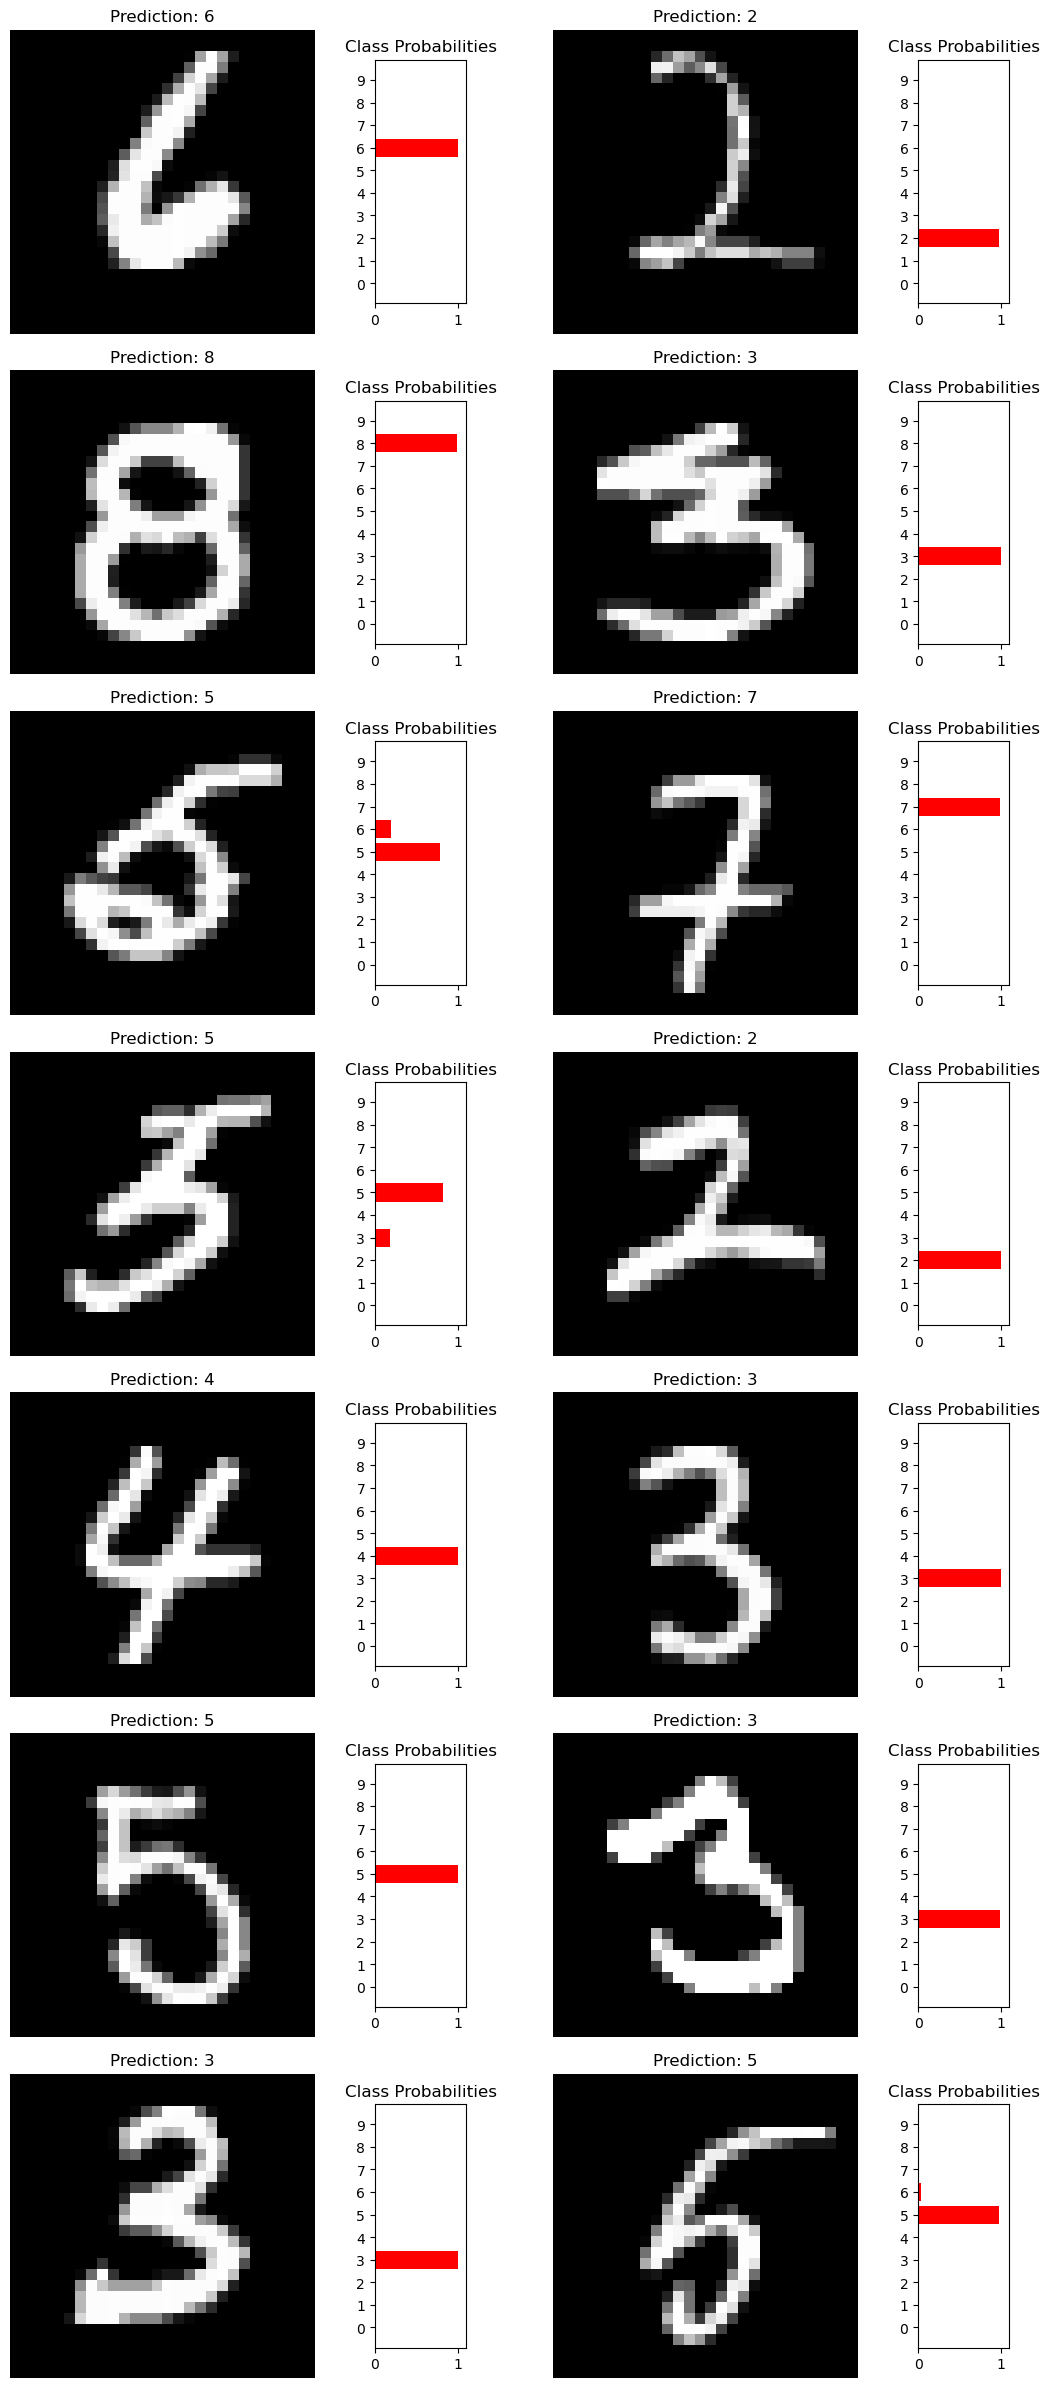

In [15]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

for i in range(1, 15):
    img = images[i].to(device).view(-1, 1, 28, 28)

    with torch.no_grad():
        logits = model(img)
    probabilities = F.softmax(logits, dim=1).cpu().numpy().squeeze()

    row = (i - 1) // 2
    col = (i - 1) % 2

    ax_img = axes[row, col]

    # Plot image
    ax_img.imshow(img.view(28, 28).cpu().numpy(), cmap="gray")
    ax_img.axis('off')
    ax_img.set_title(f"Prediction: {np.argmax(probabilities)}")

    # Add class probability bars as an inset
    inset_ax = ax_img.inset_axes([1.2, 0.1, 0.3, 0.8])
    inset_ax.barh(np.arange(10), probabilities, color='r')
    inset_ax.set_yticks(np.arange(10))
    inset_ax.set_yticklabels(np.arange(10))
    inset_ax.set_xlim(0, 1.1)
    inset_ax.set_title("Class Probabilities")

plt.tight_layout()
plt.show()


<br>

### What augmentation technique(s) did you apply?

- Random rotation (±10°) to help the model generalise better to digits tilted at slight angles

- Random Affine (translation up to 10%) to simulate hand-drawn digits appearing off-centre

- Normalisation to improve convergence during training

<br>

### How did the augmentation affect the model's accuracy and generalisation?

- Without augmentation:

    - Final test accuracy ≈ 98.72%, with smooth convergence and low final test loss(0.0396)

- With augmentation:

    - Final test accuracy ≈ 98.18%, and final test loss (0.0518)

- Observation: While the augmented model achieved slightly lower peak accuracy, it still generalised well and maintained stable performance
    - The added variability likely helped the model handle slight distortions in input more robustly

<br>

### Why do you think this augmentation was beneficial (or not)?

- Benefits:

    - Increases data variability, reducing overfitting

    - Improves robustness to real-world input variations like rotation or off-centre writing

    - Encourages the model to learn more general features rather than memorising patterns

- Challenges:

    - May slightly hinder accuracy when the test is clean and highly structured

    - Not all augmentations are helpful for digit classification 

        - flipping could be misleading

<br>

---

## Question 2: Modifying the Model Architecture  
Experiment with the architecture of the convolutional neural network. Modify at least two of the following:  
- The number of layers  
- The number of filters per layer  
- The kernel size  
- The activation functions  

After making your modifications, retrain the model and compare its performance with the original. Answer the following:  
- What specific changes did you make?  
- How did the changes impact accuracy and training time?  
- Why do you think these modifications improved or degraded the model's performance?  

In [16]:
# Data transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Data loaders
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset  = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset, batch_size=1000, shuffle=False)

# Modified CNN architecture
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=24, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64*7*7, out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=128, out_features=10)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.linear_layers(x)
        return x  # raw logits for CrossEntropyLoss

# Instantiate model, loss, optimiser
model = ModifiedCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Training and evaluation
def train(model, loader):
    model.train()
    total_loss = 0
    for data, target in loader:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def test(model, loader):
    model.eval()
    correct = 0
    total_loss = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
    accuracy = correct / len(loader.dataset)
    return total_loss / len(loader), accuracy

# Run training loop
train_losses, test_losses = [], []
for epoch in range(1, 11):
    train_loss = train(model, train_loader)
    test_loss, accuracy = test(model, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    print(f"Epoch: {epoch}/10  Training loss: {train_loss:.4f}  Testing loss: {test_loss:.4f}  Test accuracy: {accuracy:.4f}")

Epoch: 1/10  Training loss: 1.4570  Testing loss: 0.3833  Test accuracy: 0.8810
Epoch: 2/10  Training loss: 0.3563  Testing loss: 0.1772  Test accuracy: 0.9456
Epoch: 3/10  Training loss: 0.2134  Testing loss: 0.1103  Test accuracy: 0.9634
Epoch: 4/10  Training loss: 0.1598  Testing loss: 0.0959  Test accuracy: 0.9683
Epoch: 5/10  Training loss: 0.1340  Testing loss: 0.0701  Test accuracy: 0.9764
Epoch: 6/10  Training loss: 0.1143  Testing loss: 0.0604  Test accuracy: 0.9794
Epoch: 7/10  Training loss: 0.1001  Testing loss: 0.0662  Test accuracy: 0.9791
Epoch: 8/10  Training loss: 0.0933  Testing loss: 0.0478  Test accuracy: 0.9847
Epoch: 9/10  Training loss: 0.0849  Testing loss: 0.0439  Test accuracy: 0.9854
Epoch: 10/10  Training loss: 0.0800  Testing loss: 0.0425  Test accuracy: 0.9865


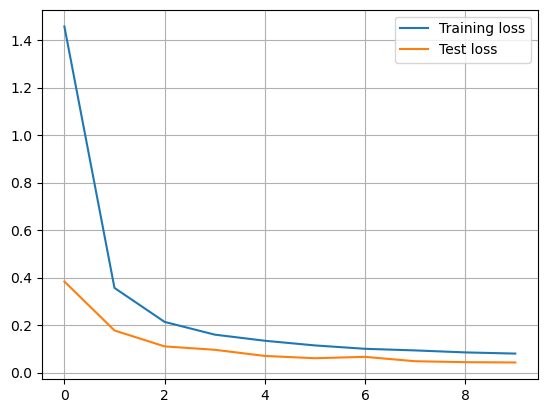

In [17]:
# Plot training and test loss curves with labels and grid for visual comparison
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in train_losses], label='Training loss')
plt.plot([loss.cpu().numpy() if isinstance(loss, torch.Tensor) else loss for loss in test_losses], label='Test loss')
plt.legend()
plt.grid()

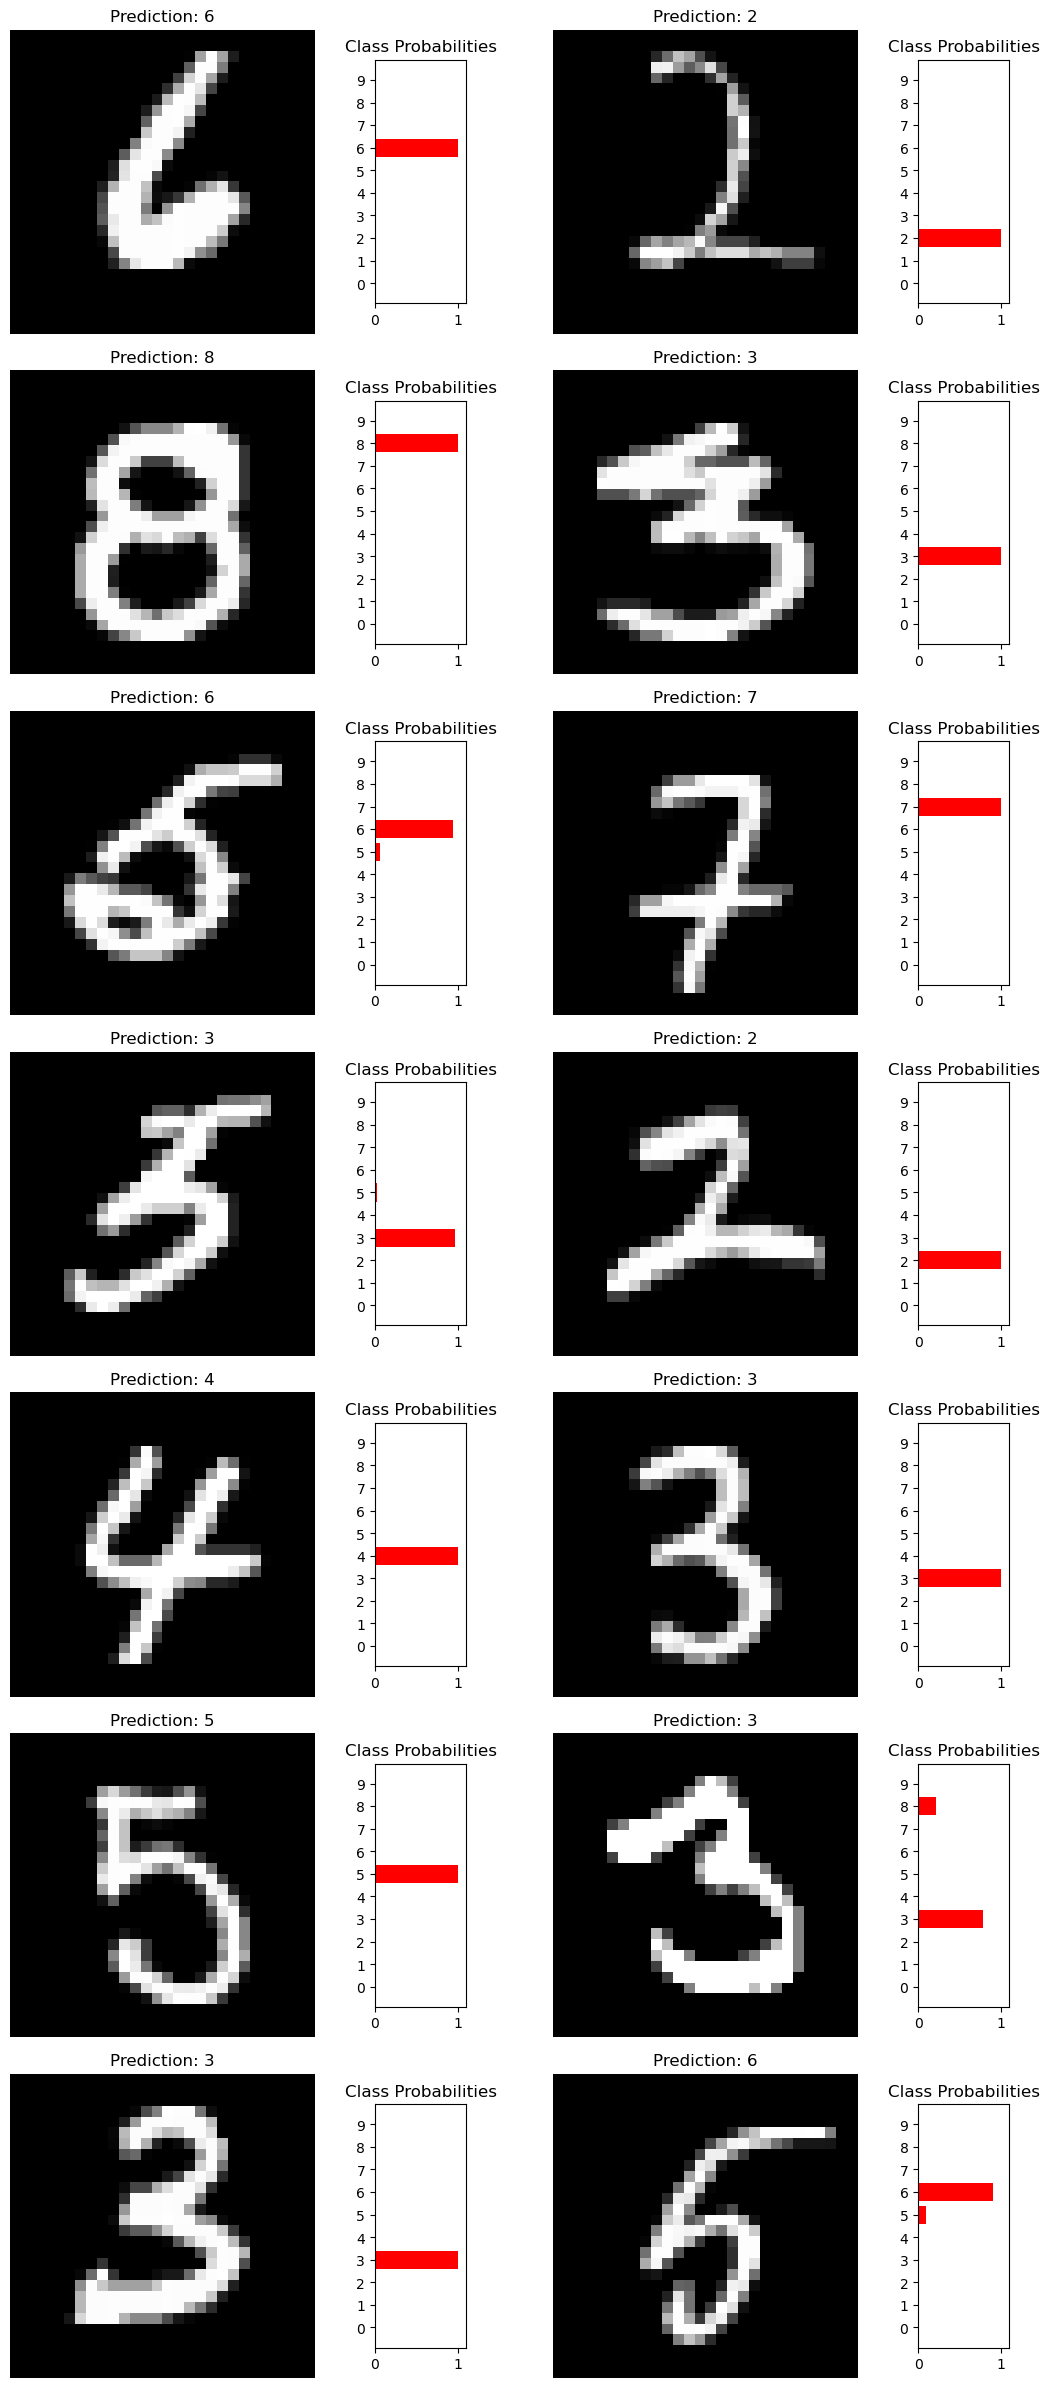

In [18]:
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(12, 24))

for i in range(1, 15):
    img = images[i].to(device).view(-1, 1, 28, 28)

    with torch.no_grad():
        logits = model(img)
    probabilities = F.softmax(logits, dim=1).cpu().numpy().squeeze()

    row = (i - 1) // 2
    col = (i - 1) % 2

    ax_img = axes[row, col]

    # Plot image
    ax_img.imshow(img.view(28, 28).cpu().numpy(), cmap="gray")
    ax_img.axis('off')
    ax_img.set_title(f"Prediction: {np.argmax(probabilities)}")

    # Add class probability bars as an inset
    inset_ax = ax_img.inset_axes([1.2, 0.1, 0.3, 0.8])
    inset_ax.barh(np.arange(10), probabilities, color='r')
    inset_ax.set_yticks(np.arange(10))
    inset_ax.set_yticklabels(np.arange(10))
    inset_ax.set_xlim(0, 1.1)
    inset_ax.set_title("Class Probabilities")

plt.tight_layout()
plt.show()


<br>

The original CNN architecture can be found in another Jupyter notebook: `lecture7_original.ipynb`

<br>

### What specific changes did you make?

I made the following modifications to the original CNN architecture:

1. Increased the number of convolutional layers from 2 to 3

2. Increased the number of filters at each later:

    - From [12, 24] → [24, 48, 64]

3. Expanded the fully connected layer:

    - From 64 → 128 hidden units

4. Raised dropout rate:

    - From 0.2 → 0.5 to enhance regularisation

5. Removed F.log_softmax from the model’s forward() method and instead passed raw logits directly to CrossEntropyLoss (to avoid double-softmaxing)

<br>

### How did the changes impact accuracy and training time?

| Metric              | Original Model              | Modified Model              |
|---------------------|------------------------------|------------------------------|
| Initial Accuracy    | 92.55%                       | 88.10%                       |
| Final Accuracy      | 98.13%                       | **98.65%**                   |
| Final Test Loss     | 0.0519                       | **0.0425**                   |
| Final Training Loss | 0.0769                       | 0.0800                       |
| Training Time       | Faster (shallower network)   | Slightly longer              |
| Convergence         | Smooth, consistent           | Fluctuated early, stabilised |

- The modified model converged more slowly at first but surpassed the original in final performance

- The final test accuracy improved by ~0.5%, and the test loss was also lower, showing strongr generalisation

<br>

### Why do you think these modifications improved or degraded the model's performance?

- Improvements:

    - Deeper architecture allowed the model to learn more complex and abstract features

    - Increased filters captured final visual patterns in digit shapes

    - Higher dropout helped regularise the deeper network, reducing overfitting risk

    - Correct use of `CrossEntropyLoss` (without redundant softmax) led to better gradient flow and more stable training

- Challenges:

    - Initially higher training loss and slower early performance due to increased complexity

    - Slight increase in training time due to the deeper model and additional parameters

<br>

---